In [67]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import mplleaflet

In [5]:
from route_shape_process_scripts import *
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import numpy as np
import time
import pandas as pd
import math
import multiprocessing
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString, MultiLineString

# import gtfs

In [3]:
full_routes_gtfs = pd.read_csv("gtfs_routes_2018-08-15_2018-12-12.csv")
full_shapes_gtfs = pd.read_csv("gtfs_shapes_2018-08-15_2018-12-12.csv")
full_trips_gtfs = pd.read_csv("gtfs_trips_2018-08-15_2018-12-12.csv")
full_trip_stop_schedule = pd.read_csv("gtfs_2018-08-15_2018-12-12.csv")

/Users/benjaminmalnor/anaconda2/envs/geopy36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# set your route, shape variables

In [6]:
route_name = 'E Line'
get_select_routeid_name(full_routes_gtfs, [route_name])[2]

{'E Line': 102615}

In [7]:
route_desc = get_select_routeid_name(full_routes_gtfs, [route_name])[0]['route_desc'].iloc[0]

In [8]:
input_dict = {'route_id':102615}
input_dict['shape_id'] = 11675003

# import

In [9]:
file_path = "route_{}_shape_{}_raw_w_nearest_2018-08-15_2018-12-11.csv".format(
                                       input_dict['route_id'], input_dict['shape_id'])
unpacked_positions_full = pd.read_csv(file_path)

# we need to grab the shape_pt_sequence and so we can match shape_pt_sequence with shape_dist_traveled TODO: make add this field earlier in the position join

In [13]:
one_shape = full_shapes_gtfs[(full_shapes_gtfs['shape_id']==input_dict['shape_id'])&\
                            (full_shapes_gtfs['start_gtfs_date']=='2018-08-15')&\
                            (full_shapes_gtfs['end_gtfs_date']=='2018-09-23')]
one_shape.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,start_gtfs_date,end_gtfs_date
130945,11675003,47.601677,-122.330170,1,0.0,2018-08-15,2018-09-23
130946,11675003,47.601719,-122.330269,2,30.0,2018-08-15,2018-09-23
130947,11675003,47.601788,-122.330429,3,78.6,2018-08-15,2018-09-23
130948,11675003,47.601826,-122.330513,4,100.4,2018-08-15,2018-09-23
130949,11675003,47.601872,-122.330566,5,123.0,2018-08-15,2018-09-23


In [14]:
unpacked_positions_full = unpacked_positions_full.merge(one_shape[['shape_pt_sequence','shape_dist_traveled']],how='left', on='shape_pt_sequence' )

In [15]:
def make_geopandas_shape_df(gtfs_shapes, shape_id):
    '''
    INPUT
    -------
    gtfs_shapes = gtfs shapes.txt file dataframe
    shape_id = one shape_id to filter on
    OUTPUT
    -------
    route_vertex_geo <-- geopandas version of a particular schedule shapes.txt geometry = route vertex points
    '''
    one_shape_df = gtfs_shapes[gtfs_shapes['shape_id'] == shape_id].copy()
    crs = {'init':'epsg:4326'}
    shape_geometry = [Point(xy) for xy in zip(one_shape_df.shape_pt_lon, one_shape_df.shape_pt_lat)]
    route_vertex_geo = GeoDataFrame(one_shape_df, crs=crs, geometry=shape_geometry)
    return route_vertex_geo

In [16]:
route_shape_vertex = make_geopandas_shape_df(full_shapes_gtfs, input_dict['shape_id'])

In [17]:
def datetime_transform_df(df):
    '''
    '''
    df['time_pct'] = df['time_utc'].apply(pd.to_datetime)
    df.set_index('time_pct', inplace=True)
    df.sort_index(inplace=True)
    df = df.tz_localize('UTC')
    df = df.tz_convert('US/Pacific')
    
    return df

In [18]:
unpacked_positions_full = datetime_transform_df(unpacked_positions_full)

In [19]:
unpacked_positions_full[['month_day_trip_veh','timestamp',
                                 'vehicle_lat','vehicle_long',
                                 'shape_pt_sequence','shape_dist_traveled'
                               ]].head(5)

,month_day_trip_veh,timestamp,vehicle_lat,vehicle_long,shape_pt_sequence,shape_dist_traveled
time_pct,,,,,,
2018-08-31 16:59:07-07:00,2018_8_31_39512518_6046,1535759947,47.723824,-122.344978,301,46768.3
2018-08-31 16:59:32-07:00,2018_8_31_39512951_2667,1535759972,47.664989,-122.347260,175,24952.0
2018-08-31 16:59:36-07:00,2018_8_31_39512547_6071,1535759976,47.698055,-122.344612,267,37476.0
2018-08-31 16:59:39-07:00,2018_8_31_39512516_6040,1535759979,47.604149,-122.332672,11,1105.0
2018-08-31 16:59:39-07:00,2018_8_31_39512611_2803,1535759979,47.712730,-122.344818,288,42836.9


In [20]:
def get_travel_rate(row):
    ##shape dist traveled is in feet, time in seconds travel_rate_update mph
    travel_rate = (row['shape_dist_diff']/row['total_seconds_delta'])*(5280)*(1/(60*60))
    return travel_rate

In [21]:
def get_distance_time_parallel(df):
    '''
    '''
    df.sort_index(inplace=True)
    df.loc[:,'shape_dist_diff'] = df.loc[:,'shape_dist_traveled'].diff(1)
    df.loc[:,'time_delta'] = df.index.to_series().diff(1)
    
    df['shape_pt_seq_tuple'] = list(zip(df.shift(1).apply(lambda x: 9999 if math.isnan(x['shape_pt_sequence']) else int(x['shape_pt_sequence']), axis=1).values,
                            df.apply(lambda x: x['shape_pt_sequence'], axis=1).values))
    
    df.dropna(axis=0, how='any', subset=['time_delta','shape_dist_diff'], inplace=True)
    
    df.loc[:,'total_seconds_delta'] = df['time_delta'].apply(lambda x: x.total_seconds())
    
    if df.empty:
        pass
    else:
        df.loc[:,'travel_rate_mph'] = df.apply(get_travel_rate, axis=1)

    return df

In [22]:
def get_distance_time_diffs(unpacked_positions_full):
    n_pools = multiprocessing.cpu_count() - 1
    pool = multiprocessing.Pool(n_pools)
    distance_time_list = []
    grouped =  unpacked_positions_full.groupby('month_day_trip_veh')
    for name, group in grouped:
        distance_time_list.append(group)
    distance_time_list_df = pd.concat(pool.map(get_distance_time_parallel, distance_time_list))
    return distance_time_list_df

# below starts the 'get_distance_time_diffs' function - if you have a windows I don't think this will work... just run it without multiprocessing

In [23]:
if __name__ == "__main__":
    start = time.time()
    distance_time_list_df = get_distance_time_diffs(unpacked_positions_full)
    end = time.time()
    print(end - start)

122.18001008033752


# flag all trip segments with travel_rate < threshold 

In [24]:
mph_rate_flag = 10 #can change
new_df = distance_time_list_df.copy()
new_df['trouble_flag'] = new_df.apply(lambda x: True if x['travel_rate_mph'] < mph_rate_flag else False, axis=1)

# isolate only the bad segments :)

In [25]:
new_df_true = new_df[new_df['trouble_flag'] == True]

In [26]:
new_df_true.reset_index(inplace=True)

In [27]:
new_df_true.head(3)

,time_pct,day,direction_id,dist_to_nearest_route_pt,dow,geometry,hour,month,month_day_trip_veh,near_node_pt,...,time_utc,timestamp,total_seconds_delta,travel_rate_mph,trip_id,vehicle_id,vehicle_lat,vehicle_long,year,trouble_flag
0,2018-10-10 17:34:46-07:00,10,0,0.000019,2,POINT (-122.3326873779297 47.60416412353516),17,10,2018_10_10_40955465_6110,"(-122.332672, 47.6041527)",...,2018-10-11 00:34:46,1539218086,180.0,9.003704,40955465,6110,47.604164,-122.332687,2018,True
1,2018-10-10 17:37:46-07:00,10,0,0.000017,2,POINT (-122.3353118896484 47.60703659057617),17,10,2018_10_10_40955465_6110,"(-122.33532, 47.6070518)",...,2018-10-11 00:37:46,1539218266,90.0,0.257481,40955465,6110,47.607037,-122.335312,2018,True
2,2018-10-10 17:45:17-07:00,10,0,0.000022,2,POINT (-122.3452835083008 47.61499786376953),17,10,2018_10_10_40955465_6110,"(-122.345268, 47.6149826)",...,2018-10-11 00:45:17,1539218717,181.0,8.817017,40955465,6110,47.614998,-122.345284,2018,True


In [28]:
def get_all_segments_parallel(row):
    '''
    '''
    col_list = ['month_day_trip_veh',
                'trip_hour',
               'time_pct',
               'trip_dow',
               'travel_rate_mph',
                'pt_seq',
               'real_obv',
               'trouble_spot_flag']
    edge_for_upload = []
    month_day_trip_veh = row['month_day_trip_veh']
    trip_hour = row['hour']
    time_pct = row['time_pct']
    trip_dow = row['dow']
    travel_rate_mph = row['travel_rate_mph']
    
    pt_seq_start = row['shape_pt_seq_tuple'][0]
    pt_seq_end = row['shape_pt_seq_tuple'][1]
    full_edge_df = pd.DataFrame()
    for idx, pt_seq in enumerate(range(pt_seq_start,pt_seq_end)):
        if idx == 0:
            real_obv = True
        else:
            real_obv = False
        trouble_spot = 1
        info_tuple = (month_day_trip_veh,
                     trip_hour,
                     time_pct,
                     trip_dow,
                     travel_rate_mph,
                      pt_seq,
                     real_obv,
                     trouble_spot)
        edge_for_upload.append(info_tuple)
        edge_df = pd.DataFrame(edge_for_upload, columns=col_list)

        
        if full_edge_df.empty:
            full_edge_df = edge_df.copy()
        else:
            full_edge_df = full_edge_df.append(edge_df)
    return full_edge_df

In [29]:
def get_segments(new_df_true):
    n_pools = multiprocessing.cpu_count() - 1
    pool = multiprocessing.Pool(n_pools)
    row_list = []
    for index, row in new_df_true.iterrows():
        row_list.append(row)
    full_edge_df = pd.concat(pool.map(get_all_segments_parallel, row_list))
    return full_edge_df

In [30]:
if __name__ == "__main__":
    start = time.time()
    full_edge_df = get_segments(new_df_true)
    end = time.time()
    print(end - start)

195.68596482276917


In [31]:
full_edge_df.head()

,month_day_trip_veh,trip_hour,time_pct,trip_dow,travel_rate_mph,pt_seq,real_obv,trouble_spot_flag
0,2018_10_10_40955465_6110,17,2018-10-10 17:34:46-07:00,2,9.003704,1,True,1
0,2018_10_10_40955465_6110,17,2018-10-10 17:34:46-07:00,2,9.003704,1,True,1
1,2018_10_10_40955465_6110,17,2018-10-10 17:34:46-07:00,2,9.003704,2,False,1
0,2018_10_10_40955465_6110,17,2018-10-10 17:34:46-07:00,2,9.003704,1,True,1
1,2018_10_10_40955465_6110,17,2018-10-10 17:34:46-07:00,2,9.003704,2,False,1


# export results - need to find an appropriate place / way to store this info

In [32]:
full_edge_df.to_csv('route_{}_shape_{}_slowspots_2018-08-15_2018-12-11.csv'.format(
                                        input_dict['route_id'], input_dict['shape_id']), index=True)

In [33]:
route_shape_vertex.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,start_gtfs_date,end_gtfs_date,geometry
130945,11675003,47.601677,-122.330170,1,0.0,2018-08-15,2018-09-23,POINT (-122.33017 47.6016769)
130946,11675003,47.601719,-122.330269,2,30.0,2018-08-15,2018-09-23,POINT (-122.330269 47.6017189)
130947,11675003,47.601788,-122.330429,3,78.6,2018-08-15,2018-09-23,POINT (-122.330429 47.6017876)
130948,11675003,47.601826,-122.330513,4,100.4,2018-08-15,2018-09-23,POINT (-122.330513 47.60182570000001)
130949,11675003,47.601872,-122.330566,5,123.0,2018-08-15,2018-09-23,POINT (-122.330566 47.6018715)


# match shape_pt_sequence to stops

In [34]:
grouped_trips = full_trip_stop_schedule.groupby(['start_gtfs_date','end_gtfs_date'])
day_trips = grouped_trips.get_group(('2018-09-24', '2018-09-24'))
shape_trips = day_trips[(day_trips['shape_id']==input_dict['shape_id'])]
route_shape_w_names = route_shape_vertex.merge(shape_trips[['stop_sequence','stop_name']], 
                                               how='left', left_on='shape_pt_sequence',
                                              right_on='stop_sequence')

In [35]:
route_shape_w_names = route_shape_w_names.drop_duplicates(subset='stop_sequence', keep='first')\
                        .copy()

In [36]:
route_shape_w_names = route_shape_w_names[route_shape_w_names.stop_sequence.notnull()].copy()

In [37]:
stop_name_dict = pd.Series(data=route_shape_w_names.stop_name.values,
          index=route_shape_w_names.shape_pt_sequence.values).to_dict()

In [38]:
morning_hours = [7,8,9]
afternoon_hours = [15,16,17,18]
peak_hours = morning_hours+afternoon_hours
all_hours = list(full_edge_df.trip_hour.unique())
offpeak_hours = [hours for hours in all_hours if hours not in peak_hours]

# all hours

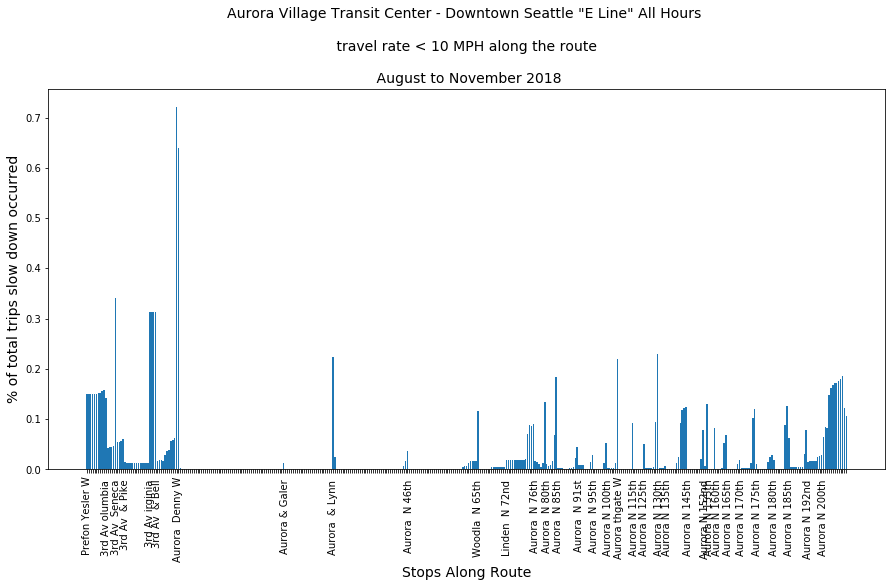

In [44]:
total_trips = len(full_edge_df.month_day_trip_veh.unique())
pivot_sums = full_edge_df.pivot_table(values='trouble_spot_flag', 
                                      index='month_day_trip_veh', 
                                      columns='pt_seq')\
                                        .sum(axis=0)/total_trips
# GET LABELS
###################
x_labels = []
for idx_num in pivot_sums.index:
    if idx_num in stop_name_dict.keys():
        idx_num_label = str(stop_name_dict[idx_num])
        label_str = idx_num_label[:6]+" "+idx_num_label[-10:-2]
        x_labels.append(label_str)
    else:
        x_labels.append("")
###################
fig, ax = plt.subplots(figsize=(15,7))
x_pos = pivot_sums.index
bar_h = pivot_sums.values
#ax.set_xticklabels(x_labels)
plt.xticks(x_pos, x_labels, rotation='vertical')
ax.bar(x_pos, bar_h)
ax.set_ylabel("% of total trips slow down occurred", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""{} \"{}\" All Hours 
                \n travel rate < 10 MPH along the route 
                \n August to November 2018""".format(route_desc,
                                                    route_name,
                                                    trip_sign))
_ = ax.set_title(title_str, fontsize=14)

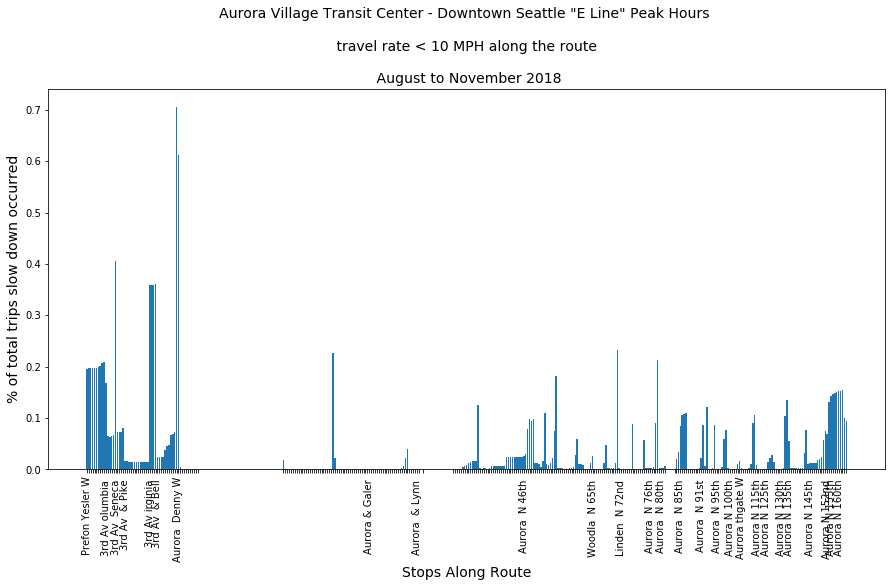

In [40]:
total_trips = len(full_edge_df[full_edge_df['trip_hour'].isin(peak_hours)]\
                                                          .month_day_trip_veh.unique())
pivot_sums = full_edge_df[full_edge_df['trip_hour'].isin(peak_hours)]\
                                                    .pivot_table(values='trouble_spot_flag', 
                                                                  index='month_day_trip_veh', 
                                                                  columns='pt_seq')\
                                                    .sum(axis=0)/total_trips
fig, ax = plt.subplots(figsize=(15,7))
x_pos = pivot_sums.index
bar_h = pivot_sums.values
ax.bar(x_pos, bar_h)
plt.xticks(x_pos, x_labels, rotation='vertical')
ax.set_ylabel("% of total trips slow down occurred", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""{} \"{}\" Peak Hours 
                \n travel rate < 10 MPH along the route 
                \n August to November 2018""".format(route_desc,
                                                    route_name,
                                                    trip_sign))
_ = ax.set_title(title_str, fontsize=14)

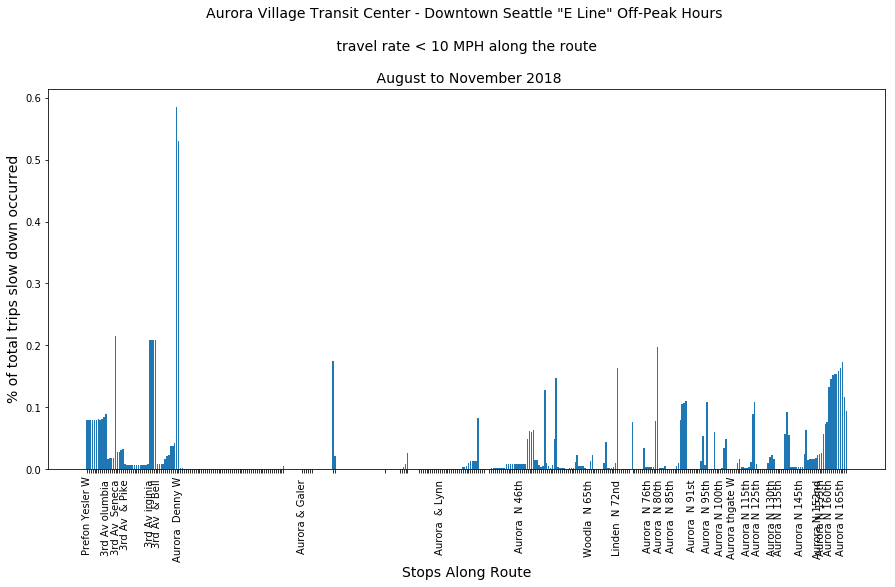

In [41]:
total_trips = len(full_edge_df[full_edge_df['trip_hour'].isin(offpeak_hours)]\
                                                          .month_day_trip_veh.unique())
pivot_sums = full_edge_df[full_edge_df['trip_hour'].isin(offpeak_hours)]\
                                                    .pivot_table(values='trouble_spot_flag', 
                                                                 index='month_day_trip_veh', 
                                                                 columns='pt_seq')\
                                                    .sum(axis=0)/total_trips
fig, ax = plt.subplots(figsize=(15,7))
x_pos = pivot_sums.index
bar_h = pivot_sums.values
ax.bar(x_pos, bar_h)
plt.xticks(x_pos, x_labels, rotation='vertical')
ax.set_ylabel("% of total trips slow down occurred", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""{} \"{}\" Off-Peak Hours 
                \n travel rate < 10 MPH along the route 
                \n August to November 2018""".format(route_desc,
                                                    route_name,
                                                    trip_sign))
_ = ax.set_title(title_str, fontsize=14)

In [48]:
full_edge_counts = full_edge_df.groupby('pt_seq').agg({'trouble_spot_flag':'sum'})\
    .reset_index()

In [49]:
route_with_counts = route_shape_vertex.merge(full_edge_counts, how='left', left_on='shape_pt_sequence', right_on='pt_seq')

In [50]:
route_with_counts.dropna(axis=0,how='any',subset=['trouble_spot_flag'], inplace=True)

# this leaflet widget does not always work for me

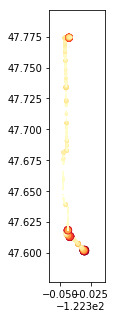

In [73]:
fig, ax = plt.subplots(figsize=(5,5))
route_with_counts.plot(ax=ax, column='trouble_spot_flag', 
                    cmap='YlOrRd',
                   markersize=route_with_counts['trouble_spot_flag'].values/200)

In [74]:
mplleaflet.show(fig=ax.figure,crs=route_with_counts.crs)

# save to geojson and view in QGIS or Tableau/PowerBI

In [66]:
route_with_counts_json = route_with_counts.to_json()
file_name = "route_{}_{}_{}_bad_speed_count.geojson".format(input_dict['route_id'],
                                                         input_dict['shape_id'], 
                                                         trip_sign)
with open(file_name, "w") as f:
    f.write(route_with_counts_json)